# Select Textures

In [5]:
import os
import glob
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn
from torchvision import transforms, datasets
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import util.util_validation as ut_val
from networks.resnet_big import SupCEResNet, SupConResNet, LinearClassifier, model_dict

In [10]:
cuda_device = 0

# untrained
# root_model = "./save/SupCE/untrained/SupCE_untrained_resnet18_lr_0.0_decay_0.0001_bsz_26_trial_0_noTraining/models/last.pth"

# cross validation:
# original data:
root_model = "./save/SupCE/animals10/SupCE_animals10_resnet18_lr_0.125_decay_0.0001_bsz_26_trial_0_baseline_cosine/models/ckpt_epoch_500.pth"
# diffused data:
# root_model = "./save/SupCE/animals10_diff_4000/SupCE_animals10_diff_4000_resnet18_lr_0.125_decay_0.0001_bsz_26_trial_0_4000_cosine/models/last.pth"
# small original dataset
# root_model = "./save/SupCE/animals10_diff_-1_small/SupCE_animals10_diff_-1_small_resnet18_lr_0.125_decay_0.0001_bsz_26_trial_0_origSmall_cosine/models/last.pth"
# small diffused dataset
# root_model = "./save/SupCE/animals10_diff_4000_small/SupCE_animals10_diff_4000_small_resnet18_lr_0.125_decay_0.0001_bsz_26_trial_0_4000Small_cosine/models/last.pth"

# supervised contrastive learning:
# with classes as positives and negatives
# original data:
# root_model = "./save/SupCon/animals10/SupCon_animals10_resnet18_lr_0.5_decay_0.0001_bsz_26_temp_0.1_trial_0_try2_cosine/models/last.pth"
# root_model = "./save/SupCon/animals10_diff_-1/SupCon_animals10_diff_-1_resnet18_lr_0.125_decay_0.0001_bsz_26_temp_0.1_trial_0_try3_cosine/models/last.pth"
# original and diffused data (with no augmentations):
# root_model = "./save/SupCon/animals10_diff_-1+4000/SupCon_animals10_diff_-1+4000_resnet18_lr_0.125_decay_0.0001_bsz_26_temp_0.1_trial_0_noAug_cosine/models/last.pth"

# with one positive and other classes as negatives
# original and diffused data (with no augmentations):
# root_model = "./save/SupCon/animals10_diff_-1+4000/SupConHybrid_animals10_diff_-1+4000_resnet18_lr_0.125_decay_0.0001_bsz_26_temp_0.1_trial_0_noAug_cosine/models/last.pth"
# original and diffused data (with color augmentations):
# root_model = "./save/SupCon/animals10_diff_-1+4000/SupConHybrid_animals10_diff_-1+4000_resnet18_lr_0.125_decay_0.0001_bsz_26_temp_0.1_trial_0_colorAug_cosine/models/last.pth"

dataset = "animals10_diff_-1"

root_textures = "./datasets/adaIN/textures_animals10/"

## Sample some images from the Dataset

In [3]:
def create_files_dataFrame(root, classes):
    """
    Creates a pandas DataFrame for a image dataset of the form ./root/class/img.png

    Parameters
    ----------
    root: str
        The path to the dataset
    classes: iterable
        Containing the class names (folder names in the dataset)

    Returns
    ---------
    : pandas.DataFrame
    DataFrame with columns image for the file names of the images
    and label for the integer class label.
    """
    images = []
    labels = []
    for i, c in enumerate(classes):
        # get all image path for a class
        img_paths = glob.glob(os.path.join(root, f"{c}/*"))

        for img_path in img_paths:
            img_file = img_path.replace(os.path.join(root, f"{c}/"), '')
            images.append(img_file)
            labels.append(i)

    return pd.DataFrame.from_dict({'image': images, 'label': labels})

def plot_sample_images(dataset, img_class):
    _, root_test = ut_val.get_root_dataset(dataset)
    image_loader = datasets.folder.default_loader

    seaborn.set_theme(style="white")

    classes = ut_val.get_classes(dataset)
    df_test = create_files_dataFrame(root_test, classes)

    sample_images = df_test[df_test.label == np.where(np.array(classes) == img_class)[0][0]].sample(10)['image'].values

    fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(12,20))
    fig.tight_layout()

    for i, img_path in enumerate(sample_images):
        print(f"{i}: {sample_images[i]}")

        img = image_loader(os.path.join(root_test, img_class, img_path))

        axs[i%5,i//5].imshow(img)
        axs[i%5,i//5].set_title(i)

0: OIP-ItUhYS0uqOJaNk2QcM5R9QHaLH.jpeg
1: OIP-BDtldHUuMEVTUKAwGKBdWQHaFo.jpeg
2: OIP-9rkCnMvainVgLkC0oiTLvQHaE8.jpeg
3: OIP-XRlN_Ak8Ldq_ty0oidhn2gHaEX.jpeg
4: OIP-ijqVUl3UWXD2zzS00L_ZMwAAAA.jpeg
5: OIP-2jq8GZqv9tScQ1UT8u0rcwHaFj.jpeg
6: OIP-A28CPn317JZyHOfKkDAk8gHaFj.jpeg
7: OIP-M45MimHbXIE_p96jClhpKQHaF6.jpeg
8: OIP-nO3NgT94rAeS7nI6XAtA7gHaJ4.jpeg
9: OIP-I_uuryghJ3TicIR79OC_SwHaJ4.jpeg


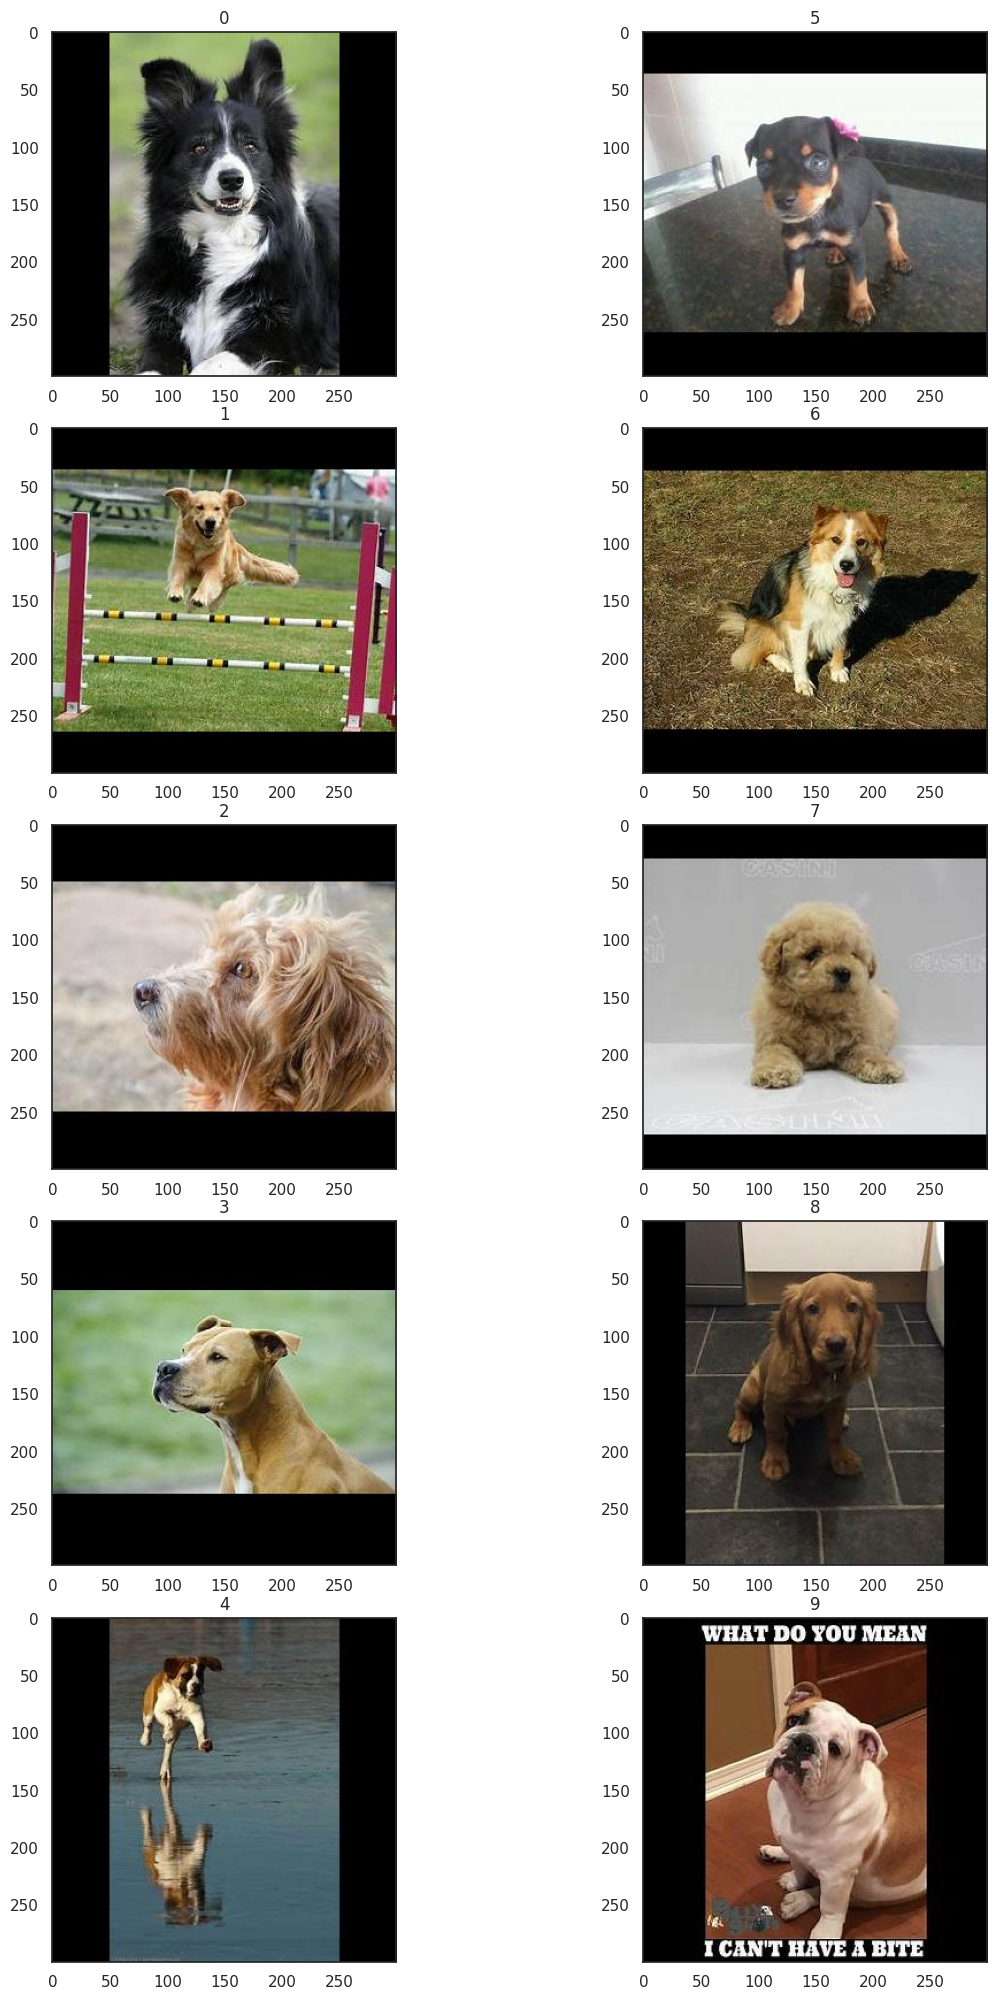

In [4]:
plot_sample_images(dataset=dataset, img_class="cane")

## Look at the predictions of the Textures

In [3]:
def evaluate_textures(root_model, root_textures, dataset, cuda_device):
    path_save, path_run_md, path_val_md, path_embeddings, epoch = ut_val.get_paths_to_embeddings_and_run_md(root_model, dataset)
    classes = ut_val.get_classes(dataset)

    params = ut_val.read_parameters_from_run_md(path_run_md)

    normalize = transforms.Normalize(mean=params['mean'], std=params['std'])
    texture_transform = transforms.Compose([transforms.Resize(params['size']), transforms.CenterCrop(params['size']), transforms.ToTensor(), normalize])
    texture_dataset = datasets.ImageFolder(root=root_textures, transform=texture_transform)
    texture_dataloader = torch.utils.data.DataLoader(texture_dataset, batch_size=params['batch_size'],
                                                     shuffle=False, num_workers=8, pin_memory=True)

    model = ut_val.set_model(root_model, params, len(classes), cuda_device)

    path_classifier = ut_val.get_path_classifier(root_model, dataset, params, epoch)
    classifier = ut_val.load_classifier_checkpoint(path_classifier, params["model"], len(classes), cuda_device)

    model.eval()
    classifier.eval()

    true_classes = []
    pred_classes = []

    for texture, labels in texture_dataloader:
        texture = texture.cuda(device=cuda_device, non_blocking=True)

        with torch.no_grad():
            features = model.encoder(texture)
            output = classifier(features)
            _, pred = output.topk(1, 1, True, True)

        true_classes.extend(labels.numpy())
        pred_classes.extend(pred.cpu().numpy().reshape(-1))

    df_pred = pd.DataFrame.from_dict({"true_class": true_classes, "pred_class": pred_classes})

    C, acc, acc_b = ut_val.get_confusion_matrix(df_pred)

    print(f"Textures: acc: {acc:.3f}, acc_b: {acc_b:.3f}")

    seaborn.set_theme(style="ticks")

    disp = ConfusionMatrixDisplay(C, display_labels=classes)
    disp.plot(xticks_rotation=45)
    for labels in disp.text_.ravel():
        labels.set_fontsize(10)
    disp.figure_.tight_layout(pad=0.5)

Textures: acc: 100.000, acc_b: 100.000


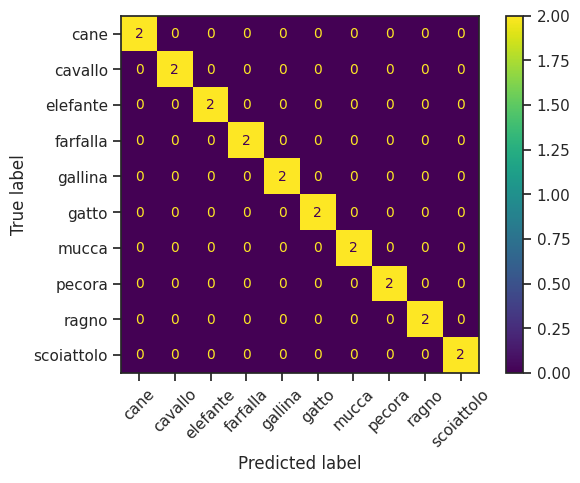

In [11]:
evaluate_textures(root_model=root_model, root_textures=root_textures, dataset=dataset, cuda_device=cuda_device)